## Ships in Satellite Imagery

### Context:

Detecting the location of large ships in satellite images.

### Content:

This dataset is from Planet satellite imagery which collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification.

label: Valued 1 representing the "ship" class, valued 0 representing the "no-ship" class.

scene id: The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.

longitude_latitude: The longitude and latitude coordinates of the image center point, with values separated by a single underscore.

80x80 RGB image is stored as a list of 19200 integers. The first 6400 entries includes the red channel values, the next 6400 is green, third 6400 is blue. 

# Data Wrangling and EDA

In [1]:
#Import the necessary modules

import json
import matplotlib.pyplot as plt
from skimage import color
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import InputLayer
from keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model, model_to_dot

Using TensorFlow backend.


In [2]:
#Check for the features
df = pd.read_json('C://Users//kurt_//Downloads//shipsnet.json//shipsnet.json')
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [3]:
#Load the dataset
f = open('C://Users//kurt_//Downloads//shipsnet.json//shipsnet.json')
dataset = json.load(f)
f.close()

In [4]:
#Convert data from list to array
data_ = np.array(dataset['data']).astype('uint8')
labels_ = np.array(dataset['labels']).astype('uint8')

#It will be seen from the shape that data includes 4000 images and every image represented as a vector of length 19200 elements.
print(data_.shape)
print(labels_.shape)

(4000, 19200)
(4000,)


In [5]:
#Check for NULL values in data and labels
print(np.isnan(data_).sum())
print(np.isnan(labels_).sum())

0
0


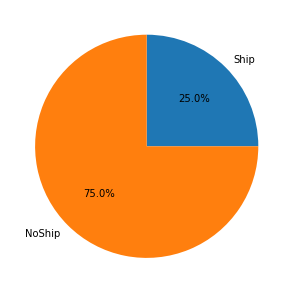

Number of ship: 1000
Number of no-ship: 3000


In [6]:
#Check for ship/no-ship numbers 
number_ship = np.sum(labels_==1)
number_noship = np.sum(labels_==0)

sizes = [number_ship, number_noship]
titles = "Ship", "NoShip"

fig = plt.figure(figsize=(5, 7))
plt.pie(sizes, labels=titles, autopct='%1.1f%%')
plt.show() 

print('Number of ship:', number_ship)
print('Number of no-ship:', number_noship)

In [5]:
# color channel 3:RGB
n_spct = 3
w = 80
h = 80
data_ = data_.reshape([-1, n_spct, w, h])

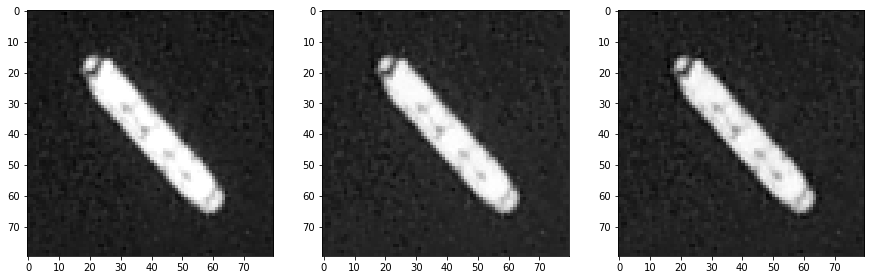

In [6]:
# get one channel
pic = data_[0]

red_spct = pic[0]
green_spct = pic[1]
blue_spct = pic[2]

#Plot each channel
plt.figure(figsize=(15, 5))
plt.set_cmap('gray')

plt.subplot(1, 3, 1)
plt.imshow(red_spct)

plt.subplot(1, 3, 2)
plt.imshow(green_spct)

plt.subplot(1, 3, 3)
plt.imshow(blue_spct)

plt.show()

In [7]:
# check for shapes
print(data_.shape)
print(labels_.shape)

(4000, 3, 80, 80)
(4000,)


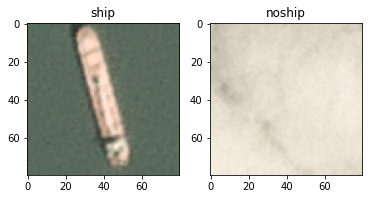

In [8]:
# reshape the data and check for an image with ship-noship
data = data_.transpose([0, 2, 3, 1])
ship = data[labels_==1]
noship = data[labels_==0]

def plot_(x, y):
    
    plt.figure(figsize=(6, 8))

    plt.subplot(1, 2, 1)
    plt.title('ship')
    plt.imshow(x[100])

    plt.subplot(1, 2, 2)
    plt.title('noship')
    plt.imshow(y[100])

    plt.show()

plot_(ship, noship)

# Pre-Processing

The original batch of images will be splitted into train and test parts. 0.8 for training and 0.2 for test.

In [9]:
# normalize the images
X = data/255

# one-hot encoding: representation of categorical variables as binary vectors
y = to_categorical(labels_, num_classes=2)

In [10]:
# split data into train-test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 123, 
                                                  stratify=y)

In [11]:
# check the shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 80, 80, 3)
(800, 80, 80, 3)
(3200, 2)
(800, 2)


# Modeling

In [12]:
# create sequential model
model = Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) 
model.add(keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(80, 80, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) 
model.add(keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', input_shape=(80, 80, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) 
model.add(keras.layers.Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       7

In [15]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# training the model for 25 epochs without augmenting the images
history1 = model.fit(X_train, y_train,
                    epochs=25,
                    validation_split=0.2,
                    batch_size=32,
                    verbose=2)

Epoch 1/25
80/80 - 15s - loss: 0.5046 - accuracy: 0.8086 - val_loss: 0.2571 - val_accuracy: 0.8953
Epoch 2/25
80/80 - 20s - loss: 0.2518 - accuracy: 0.8992 - val_loss: 0.2138 - val_accuracy: 0.9141
Epoch 3/25
80/80 - 20s - loss: 0.2007 - accuracy: 0.9176 - val_loss: 0.2172 - val_accuracy: 0.9172
Epoch 4/25
80/80 - 19s - loss: 0.1731 - accuracy: 0.9305 - val_loss: 0.1949 - val_accuracy: 0.9375
Epoch 5/25
80/80 - 19s - loss: 0.1578 - accuracy: 0.9371 - val_loss: 0.1370 - val_accuracy: 0.9578
Epoch 6/25
80/80 - 18s - loss: 0.1358 - accuracy: 0.9496 - val_loss: 0.1600 - val_accuracy: 0.9484
Epoch 7/25
80/80 - 19s - loss: 0.1259 - accuracy: 0.9535 - val_loss: 0.1008 - val_accuracy: 0.9703
Epoch 8/25
80/80 - 21s - loss: 0.1087 - accuracy: 0.9609 - val_loss: 0.0944 - val_accuracy: 0.9750
Epoch 9/25
80/80 - 20s - loss: 0.0752 - accuracy: 0.9727 - val_loss: 0.1136 - val_accuracy: 0.9484
Epoch 10/25
80/80 - 18s - loss: 0.0689 - accuracy: 0.9730 - val_loss: 0.0541 - val_accuracy: 0.9828
Epoch 11/

In [17]:
model.evaluate(X_test, y_test)

25/25 [==============================] - 2s 71ms/step - loss: 0.0664 - accuracy: 0.9837


[0.06642612814903259, 0.9837499856948853]

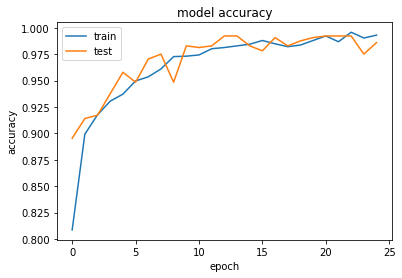

In [18]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

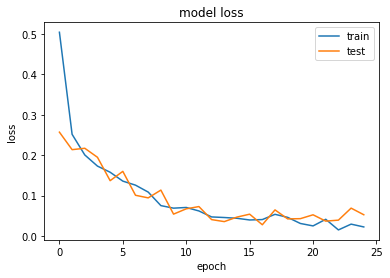

In [19]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [13]:
# label the images as noship-ship
names = ['noship', 'ship']
names_label = {name:i for i, name in enumerate (names)}

In [21]:
# predict on testing data
pred_X1= model.predict(X_test)
pred_X1 = np.argmax(pred_X1, axis=1)

test_y1 = np.argmax(y_test, axis=1)

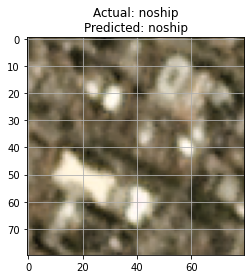

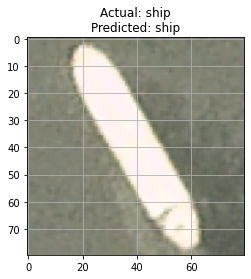

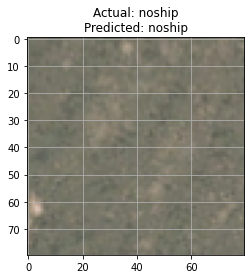

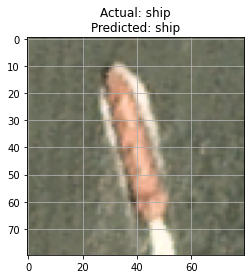

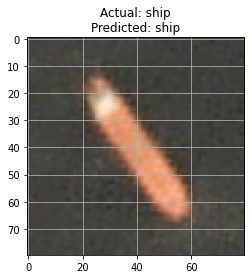

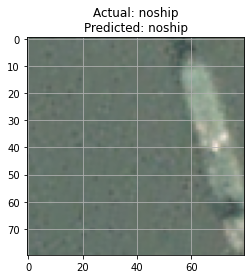

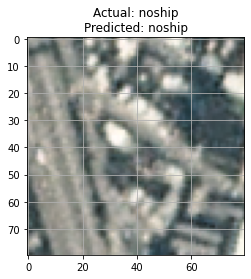

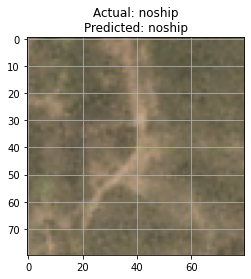

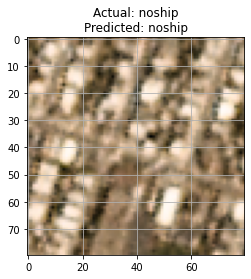

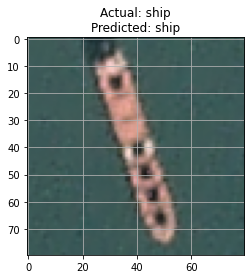

In [22]:
# check the model
rnd_smp = random.sample(range(0,400),10)
_labels_ = {i:name for (name,i) in names_label.items()}

for i, smp in enumerate(rnd_smp):
    
    plt.imshow(X_test[smp])
    plt.title("Actual: {}\nPredicted: {}".format(_labels_[test_y1[smp]], _labels_[pred_X1[smp]]))
    plt.grid(None)
    plt.show()
    pass

Apply data augmentation

In [14]:
# learning rate will be applied to model for data augmentation
optimizer = keras.optimizers.Adam(lr=0.00001)

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
# apply the augmentation technique to the training images
train_datagen = ImageDataGenerator(
        brightness_range=(0.2, 0.8),
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest',
        validation_split=0.2)

In [16]:
# train the model and see if the augmentations have any positive effect on the result
history2 = model.fit(train_datagen.flow(X_train, y_train,
                                       batch_size=32, 
                                       seed=27,
                                       shuffle=False),
                    epochs=15,
                    steps_per_epoch=X_train.shape[0] // 32,
                    validation_data=(X_test, y_test),
                    verbose=2)

Epoch 1/15
100/100 - 24s - loss: 19.7116 - accuracy: 0.6634 - val_loss: 0.6562 - val_accuracy: 0.8050
Epoch 2/15
100/100 - 27s - loss: 9.3231 - accuracy: 0.7134 - val_loss: 0.6527 - val_accuracy: 0.7937
Epoch 3/15
100/100 - 29s - loss: 7.3032 - accuracy: 0.7316 - val_loss: 0.6649 - val_accuracy: 0.7950
Epoch 4/15
100/100 - 29s - loss: 4.9798 - accuracy: 0.7428 - val_loss: 0.6742 - val_accuracy: 0.8125
Epoch 5/15
100/100 - 27s - loss: 4.4284 - accuracy: 0.7372 - val_loss: 0.6773 - val_accuracy: 0.8213
Epoch 6/15
100/100 - 27s - loss: 3.6928 - accuracy: 0.7516 - val_loss: 0.6798 - val_accuracy: 0.8350
Epoch 7/15
100/100 - 30s - loss: 3.1970 - accuracy: 0.7572 - val_loss: 0.6811 - val_accuracy: 0.8425
Epoch 8/15
100/100 - 29s - loss: 2.7445 - accuracy: 0.7616 - val_loss: 0.6815 - val_accuracy: 0.8425
Epoch 9/15
100/100 - 26s - loss: 2.6494 - accuracy: 0.7691 - val_loss: 0.6820 - val_accuracy: 0.8475
Epoch 10/15
100/100 - 26s - loss: 2.5300 - accuracy: 0.7541 - val_loss: 0.6827 - val_accur

In [17]:
model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 42ms/step - loss: 0.6875 - accuracy: 0.8662


[0.6875375509262085, 0.8662499785423279]

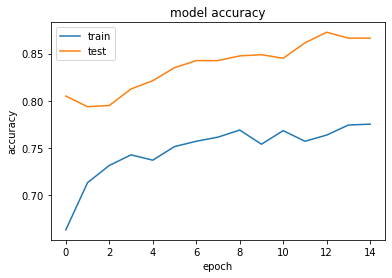

In [18]:
#Summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

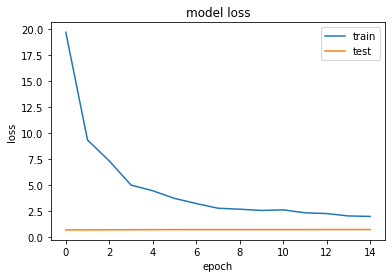

In [19]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [20]:
# predict on testing data
pred_y2= model.predict(X_test)
pred_y2[pred_y2>0.5] = 1
pred_y2[pred_y2<0.5] = 0
pred_y2 = np.argmax(pred_y2, axis=1)

In [21]:
test_y2 = np.argmax(y_test, axis=1)

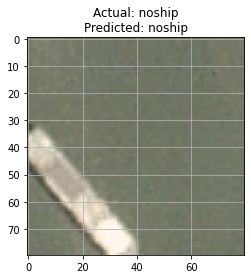

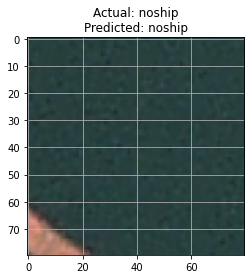

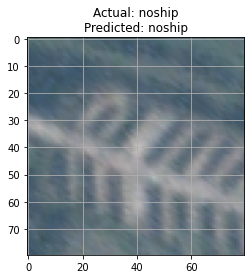

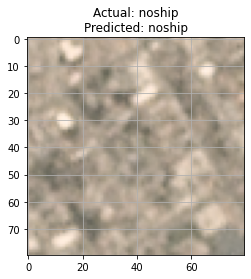

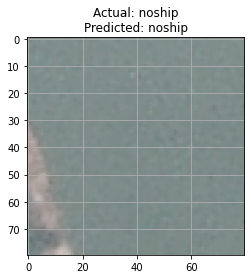

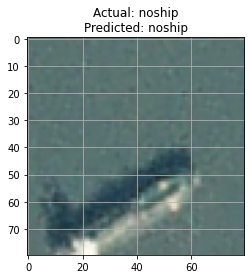

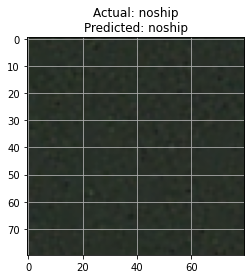

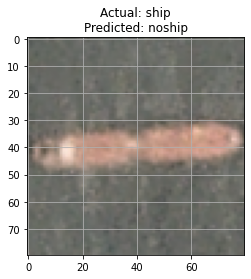

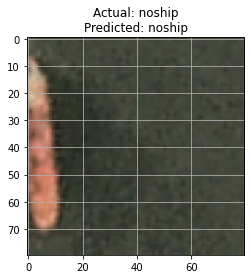

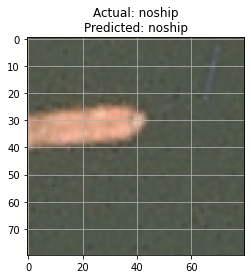

In [37]:
# check the model
rnd_smp = random.sample(range(0,400),10)
_labels_ = {i:name for (name,i) in names_label.items()}

for i, smp in enumerate(rnd_smp):
    
    plt.imshow(X_test[smp])
    plt.title("Actual: {}\nPredicted: {}".format(_labels_[test_y2[smp]], _labels_[pred_y2[smp]]))
    plt.grid(None)
    plt.show()
    pass

# Conclusion

According to the model result, the accuracy without data augmentation is 0.98. However, the accuracy with data augmentation is 0.86.